In [1]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from tensorflow import keras
import sys
from pathlib import Path
SELFIES_coder_path = Path("../SELFIES_coder")
sys.path.append(SELFIES_coder_path.as_posix())
import SELFIES_coder as SELFIES_CODER
import selfies as sf
import time

In [2]:
start = time.time()

In [3]:
SELFIES_CODER.TEST()

working


In [4]:
mol_seq_to_latent_model = keras.models.load_model('../model/mol_seq2lat_ZINC.h5')

2022-04-02 18:51:52.177856: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-02 18:51:54.248485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9643 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-04-02 18:51:54.249296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9643 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-04-02 18:51:54.249995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/repli

In [5]:
mol_seq_to_latent_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 33)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        82944       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 256)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']             

In [6]:
latent_to_states_model = keras.models.load_model("../model/lat2state_ZINC.h5")

In [7]:
latent_to_states_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 128)          16512       ['input_3[0][0]']                
                                                                                                  
Total params: 33,024
Trainable params: 33,024
Non-trainable params: 0
__________________________________________________________________________________________________


In [8]:
sample_model = keras.models.load_model("../model/samplemodel_ZINC.h5")

In [9]:
sample_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(1, 1, 33)]              0         
                                                                 
 lstm_2 (LSTM)               (1, 1, 128)               82944     
                                                                 
 dense_4 (Dense)             (1, 1, 33)                4257      
                                                                 
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


#### SMILES SHOULD BE VECTORIZED

In [10]:
# Initial structures to make predictions

smifile = "Prediction_initializers_ROR_activ.xlsx"
data = pd.read_excel(smifile)
data = data['SMILES']

In [11]:
frame = pd.DataFrame(data)
frame.head()

,SMILES
0,CCC(=O)Nc1ccc2nn(-c3ccc(CC)cc3)nc2c1
1,Cc1cccc(C(=O)Nc2cc(-c3ccccc3)no2)c1
2,CC(=O)N1CCN(Cc2ccc(-c3ccc(C(O)(C(F)(F)F)C(F)(F...
3,CC(=O)Nc1ccc2c(c1)CCCN2Cc1ccc(C(O)(C(F)(F)F)C(...
4,O=C(O)C1CCC(c2nn(C(=O)c3c(Cl)cccc3C(F)(F)F)c3c...


# Only data shorter than embed value can be used

In [12]:
smiles_train = frame['SMILES']
smiles_train

0                 CCC(=O)Nc1ccc2nn(-c3ccc(CC)cc3)nc2c1
1                  Cc1cccc(C(=O)Nc2cc(-c3ccccc3)no2)c1
2    CC(=O)N1CCN(Cc2ccc(-c3ccc(C(O)(C(F)(F)F)C(F)(F...
3    CC(=O)Nc1ccc2c(c1)CCCN2Cc1ccc(C(O)(C(F)(F)F)C(...
4    O=C(O)C1CCC(c2nn(C(=O)c3c(Cl)cccc3C(F)(F)F)c3c...
Name: SMILES, dtype: object

In [13]:
#should be equal to [(None, x -THIS, y)] from first loaded model
embed = 64+1 #x+1

In [14]:
import json
f = open('../model/mol_seq_to_int.json')
char_to_int = json.load(f)

In [15]:
charset = char_to_int.keys()

In [16]:
to_be_used = len(charset)

In [17]:
import json
f = open('../model/int_to_mol_seq.json')
int_to_char = json.load(f)

In [18]:
int_to_char = {int(key):int_to_char[key] for key in int_to_char} #removed '' -string form of data

In [19]:
import json
f = open('../model/mol_seq_to_SELFIES.json')
One_hot_to_SELFIES = json.load(f)

In [20]:
import json
f = open('../model/SELFIES_to_mol_seq.json')
SELFIES_to_one_hot = json.load(f)

In [21]:
SELFIES_to_one_hot

{'[I]': '#',
 '[#Branch1]': '$',
 '[#N]': '%',
 '[NH1]': '&',
 '[=S]': "'",
 '[#C]': '(',
 '[Ring2]': ')',
 '[N-1]': '*',
 '[Ring1]': '+',
 '[=N]': ',',
 '[N]': '-',
 '[Cl]': '.',
 '[=Branch1]': '/',
 '[=N-1]': '0',
 '[=C]': '1',
 '[CH0]': '2',
 '[O-1]': '3',
 '[=N+1]': '4',
 '[Br]': '5',
 '[O]': '6',
 '[S]': '7',
 '[C]': '8',
 '[=Ring1]': '9',
 '[N+1]': ':',
 '[Branch1]': ';',
 '[#Branch2]': '<',
 '[=O]': '=',
 '[=Branch2]': '>',
 '[=Ring2]': '@',
 '[F]': 'A',
 '[Branch2]': 'B'}

In [22]:
data = []
for SMI in list(smiles_train):
    new = SELFIES_CODER.SMILES_to_SELFIES(SMI)
    data.append(new)

In [23]:
data[0]

'[C][C][C][=Branch1][C][=O][N][C][C][=C][C][=N][N][Branch1][=N][C][=C][C][=C][Branch1][Ring1][C][C][C][=C][Ring1][Branch2][N][=C][Ring1][=N][C][=Ring1][P]'

In [24]:
SELFIES_CODER.SELFIES_to_SMILES(data[0])

'CCC(=O)NC=1C=CC2=NN(C3=CC=C(CC)C=C3)N=C2C=1'

In [25]:
list(smiles_train)[0]

'CCC(=O)Nc1ccc2nn(-c3ccc(CC)cc3)nc2c1'

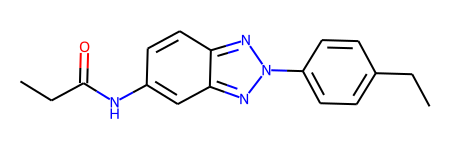

In [26]:
Chem.MolFromSmiles(SELFIES_CODER.SELFIES_to_SMILES(data[0]))

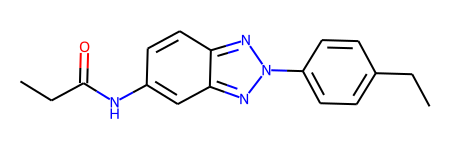

In [27]:
Chem.MolFromSmiles(list(smiles_train)[0])

## Proper translation of molecule

In [28]:
data_ = SELFIES_CODER.make_array(data)

In [29]:
translation = SELFIES_CODER.translate_SELFIES_array_into_one_hot(data_, SELFIES_to_one_hot)

In [30]:
translation[0]

'888/8=-8818,-;,8181;+8881+B-1+,89'

In [31]:
decoded_SELFIES = []
for i in range(len(translation)):
    decoded_ = SELFIES_CODER.convert_back_to_SEFLIES(translation[i], One_hot_to_SELFIES)
    decoded_SELFIES.append(decoded_)
decoded_SELFIES[0]

'[C][C][C][=Branch1][C][=O][N][C][C][=C][C][=N][N][Branch1][=N][C][=C][C][=C][Branch1][Ring1][C][C][C][=C][Ring1][Branch2][N][=C][Ring1][=N][C][=Ring1]'

In [33]:
data = translation

In [34]:
shap = len(list(smiles_train))
shap

5

In [35]:
#vectorization of SMILES code
def vectorize(mol_seqs, shap):
        one_hot =  np.zeros((shap, embed , len(charset)),dtype=np.int8)
        for i,mol_seq in enumerate(mol_seqs):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(mol_seq):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(mol_seq)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
mol_seqs_pred_ = data

X_train = vectorize(mol_seqs_pred_, shap)

print(smiles_train.iloc[0])

CCC(=O)Nc1ccc2nn(-c3ccc(CC)cc3)nc2c1


In [36]:
mol_seqs_pred_[0:5]

['888/8=-8818,-;,8181;+8881+B-1+,89',
 '881818B+$8/8=-818;>818181+/,6+61)+)',
 '88/8=-88-B)(88181B)88181B+$8;86;>8;8A;8AA8;8A;8AA81+781)+/88)+,',
 '88/8=-81818/)1+/888-+$88181B+$8;86;>8;8A;8AA8;8A;8AA81+7',
 '61;868888B)-8,-B+B8/8=81;8.8181+$8;8A;8AA81;8A8181)+$+$18)+,6']

In [37]:
#going back from vectorized form to redable string
string_test = "".join([int_to_char[idx] for idx in np.argmax(X_train[0][1,:,:], axis=1)])
print(string_test)

decoded = SELFIES_CODER.convert_back_to_SEFLIES(string_test, One_hot_to_SELFIES)
print(decoded)

decoded_two = SELFIES_CODER.convert_back_to_SEFLIES(mol_seqs_pred_[1], One_hot_to_SELFIES)
print(decoded_two)

print("Correct encoding-decoding: "+str(decoded == decoded_two))

!881818B+$8/8=-818;>818181+/,6+61)+)EEEEEEEEEEEEEEEEEEEEEEEEEEEE
[C][C][=C][C][=C][C][Branch2][Ring1][#Branch1][C][=Branch1][C][=O][N][C][=C][C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][=N][O][Ring1][O][=C][Ring2][Ring1][Ring2]
[C][C][=C][C][=C][C][Branch2][Ring1][#Branch1][C][=Branch1][C][=O][N][C][=C][C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][=N][O][Ring1][O][=C][Ring2][Ring1][Ring2]
Correct encoding-decoding: True


In [38]:
mol_seqs_pred_[1]

'881818B+$8/8=-818;>818181+/,6+61)+)'

In [39]:
new_smi_approach = vectorize(mol_seqs_pred_, shap)

In [40]:
new_smi_approach[0:1]

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,


In [41]:
len(new_smi_approach[0])

5

In [42]:
new_smi_approach[0].shape #INPUT

(5, 64, 33)

In [43]:
new_smi_approach[1].shape #OUTPUT

(5, 64, 33)

In [44]:
x_latent_new = mol_seq_to_latent_model.predict(new_smi_approach[0:1])

2022-04-02 18:51:56.472582: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


In [45]:
x_latent_new.shape

(5, 128)

In [46]:
x_latent_new[2]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.584456  ,  9.802526  ,  0.        ,  0.        ,  0.        ,
       12.405056  ,  0.        ,  0.        ,  0.        ,  3.7368047 ,
        0.        ,  2.6242647 ,  0.        ,  0.41543505,  0.        ,
        0.        ,  0.        , 16.085274  ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  3.427141  ,  0.        ,
       11.617211  ,  0.        , 10.993842  ,  0.        ,  3.9590921 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.6619225 ,  0.        ,  2.0222712 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [47]:
x_latent_new[3]

array([ 0.        ,  0.        ,  4.5513444 ,  0.        ,  0.        ,
        0.        ,  0.        ,  5.3016024 ,  0.        ,  0.        ,
        6.745746  ,  9.04259   ,  0.        ,  0.        ,  0.92726547,
        5.1458774 ,  8.909973  ,  0.        ,  0.        ,  1.0156834 ,
        0.        ,  9.495471  ,  3.5299888 ,  0.        ,  0.        ,
        0.        ,  0.        , 14.455569  ,  0.        ,  2.027134  ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 12.817474  ,  2.0698652 ,
        4.1318474 ,  1.8878082 ,  9.553898  ,  0.        ,  0.08488098,
        0.        ,  0.        ,  3.938186  ,  0.        , 10.042682  ,
        8.6908865 ,  1.0974318 ,  5.887688  ,  0.        ,  0.        ,
        5.976944  ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  6.5228324 ,  0.        ,  0.        ,
        0.        ,  6.832501  ,  0.        ,  0.        ,  0.  

In [48]:
x_latent_new[2:3]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.584456  ,  9.802526  ,  0.        ,  0.        ,  0.        ,
        12.405056  ,  0.        ,  0.        ,  0.        ,  3.7368047 ,
         0.        ,  2.6242647 ,  0.        ,  0.41543505,  0.        ,
         0.        ,  0.        , 16.085274  ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  3.427141  ,  0.        ,
        11.617211  ,  0.        , 10.993842  ,  0.        ,  3.9590921 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.6619225 ,  0.        ,  2.0222712 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [49]:
def latent_to_mol_seq(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,len(charset))) #last value should be eddited
    samplevec[0,0,startidx] = 1
    mol_seq = ""
    #Loop and predict next char
    for i in range(embed): #range is the smiles length - should be properly fixed
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            mol_seq = mol_seq + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,len(charset))) #last value should be eddited
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return mol_seq

In [50]:
molecular_sequence = latent_to_mol_seq(x_latent_new[0:1])

In [51]:
molecular_sequence

'888/8=-881-1;1-8,&81+;888+;&-1+(:;5.'

In [52]:
decoded = SELFIES_CODER.convert_back_to_SEFLIES(molecular_sequence, One_hot_to_SELFIES)
print(decoded)

[C][C][C][=Branch1][C][=O][N][C][C][=C][N][=C][Branch1][=C][N][C][=N][NH1][C][=C][Ring1][Branch1][C][C][C][Ring1][Branch1][NH1][N][=C][Ring1][#C][N+1][Branch1][Br][Cl]


In [53]:
def SELFIES_to_SMILES(SELFIES):
    
    smi = sf.decoder(SELFIES)
    
    return smi

In [54]:
new_SMILES = SELFIES_to_SMILES(decoded)
print(new_SMILES)

CCC(=O)NCC=C1N=C(NC2=N[NH1]C3=C2CCC3)[NH1]N=C1[N+1]Cl


In [55]:
#Sample around the latent wector
scale = 0.10
mols = []

for i in range(x_latent_new.shape[0]):
    for elem in range(20):
        latent_r = x_latent_new[i:i+1] + scale*(np.random.randn(x_latent_new[i:i+1].shape[1]))
        mol_seq = latent_to_mol_seq(latent_r)
        decoded = SELFIES_CODER.convert_back_to_SEFLIES(mol_seq, One_hot_to_SELFIES)
        new_SMI = SELFIES_to_SMILES(decoded)
        mol = Chem.MolFromSmiles(new_SMI)
        if mol:
            mols.append(new_SMI)
        
            print(i+1, "run ",elem+1, 'try, ', 'Correct molecule...', ' ', new_SMI)
        else:
            print(i+1, "run ",elem+1, 'try,', "ERROR", ' ', new_SMI)

1 run  1 try,  Correct molecule...   CCC(=O)NCC1=CN(C2=NC=NC(C#N)=C2C)C1SOC
1 run  2 try,  Correct molecule...   CCC(=O)NCC1=CC=NN1S2C=C(C3=CC=CC=C3F)N[NH1]2
1 run  3 try,  Correct molecule...   CCC(=O)NCC=1C=NC=C(S(=O)(=O)C(C)CC#N)N=1
1 run  4 try,  Correct molecule...   CCC(=O)N1CC2C(C#N)(S(=O)C3=CC=CC=N3)CC12
1 run  5 try,  Correct molecule...   CCC(=O)N1C=2C=CN(C3=NC=NC(C#N)=C3C)C=2S1C
1 run  6 try,  Correct molecule...   CCC(=O)NCC(C1)=NN=C(C2=CC=C(C)C(CF)=C2)S1
1 run  7 try,  Correct molecule...   CCC(=O)NCC1=CC=NN1S=2C=C(C3=CC=CC=C3F)NC=2C
1 run  8 try,  Correct molecule...   CCC(=O)NC1C=C2N(C3=NC(CC=C3)C=C2)C1C
1 run  9 try,  Correct molecule...   CCC(=O)NCC1=CC=NN1N2[NH1]C3=C(C2CC3C)NO
1 run  10 try,  Correct molecule...   CCC(=O)NCC=C1N=C(CC2=N[NH1]C3=C2CCO3)[NH1]C=C1
1 run  11 try,  Correct molecule...   CCC(=O)NCC1C(C2=N[NH1]C=C2C(C)(C)O)N=C1N
1 run  12 try,  Correct molecule...   C1CC(=O)NCC=CC=NN=C1C(C)C2=CC=CS2N
1 run  13 try,  Correct molecule...   CCC(=O)NCC1=CC=NN1SC2

5 run  18 try,  Correct molecule...   C#CN=CNCCCC=1CC=CC2=CC=CC=C2SC3=CC=CC4=C[NH1]C=CC=CC=C4C3CC=1C
5 run  19 try,  Correct molecule...   C1C(CCCNCC2CCCCC1)C=CC=C(C=C=C=CC=CC3=CC=CC4=C3)C=CC=C24
5 run  20 try,  Correct molecule...   C1#CN=CC(=O)NCCCCC2=CC=C3C=C[NH1]C=C1C=CC=CC=C4C=CC=CC4=C3CCOC2


In [56]:
len(mols)

100

In [57]:
def remove_duplicates_from_list(x_list):
    
      return list(dict.fromkeys(x_list))

In [58]:
mols = remove_duplicates_from_list(mols)

In [59]:
len(mols)

55

In [60]:
mols_ = []
for smi in mols:
    xcv = Chem.MolFromSmiles(smi)
    mols_.append(xcv)

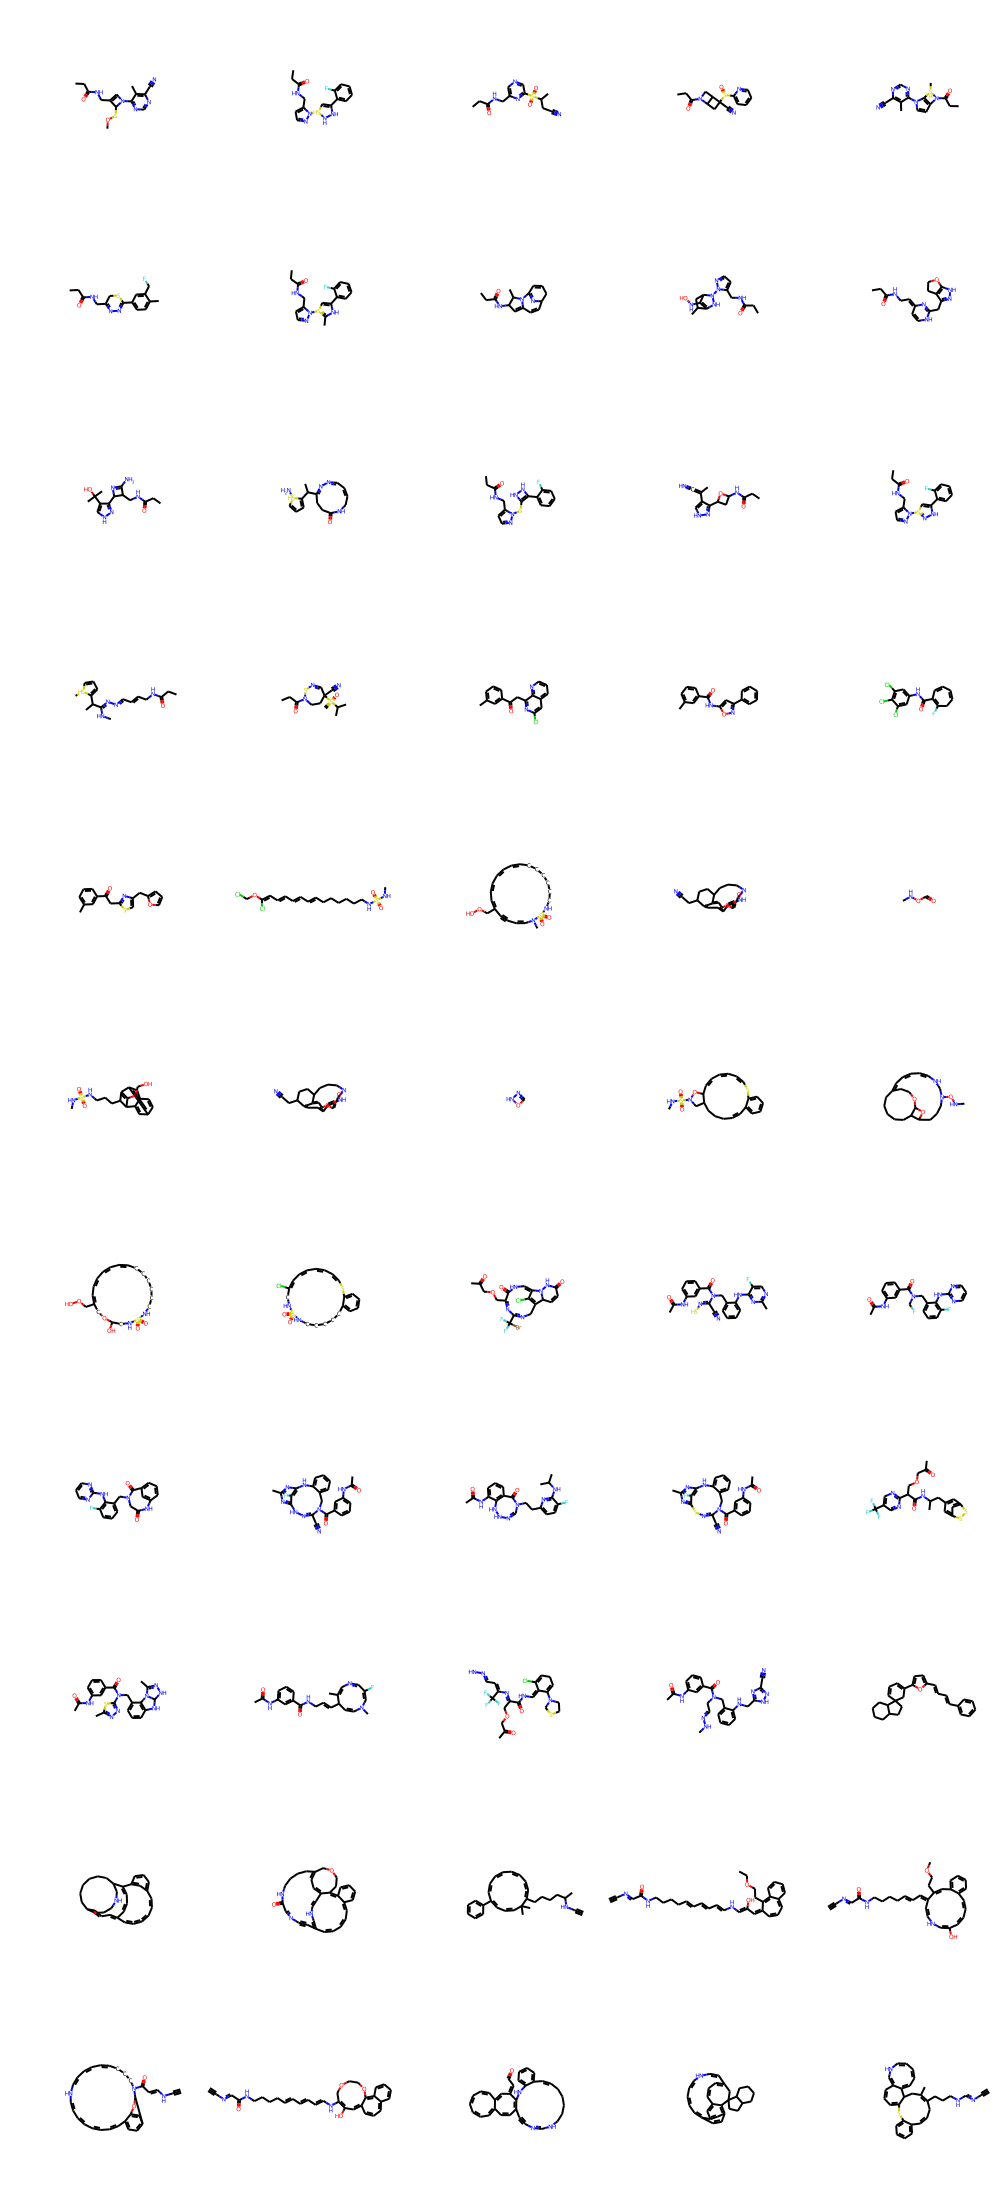

In [61]:
Draw.MolsToGridImage(mols_, molsPerRow=5, maxMols=int(len(mols)+5))

In [62]:
dataframe_created_molecules = pd.DataFrame(mols, columns=["SMILES_From_Tensor_rotation"])
dataframe_created_molecules.to_excel('Molecules_generated_tensor_scaling_0_1.xlsx')

# deciphered SMILES

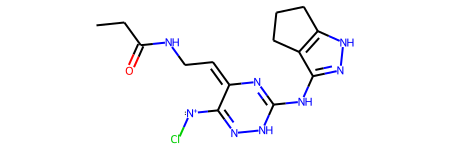

In [63]:
Chem.MolFromSmiles(SELFIES_to_SMILES(SELFIES_CODER.convert_back_to_SEFLIES(molecular_sequence, One_hot_to_SELFIES)))

# original SMILES

In [64]:
list(smiles_train)[0]

'CCC(=O)Nc1ccc2nn(-c3ccc(CC)cc3)nc2c1'

In [65]:
smiles_trainn = {smiles:Chem.MolFromSmiles(list(smiles_train)[smiles]) for smiles in range(len(smiles_train))}
smiles_trainn = list(smiles_trainn.values())

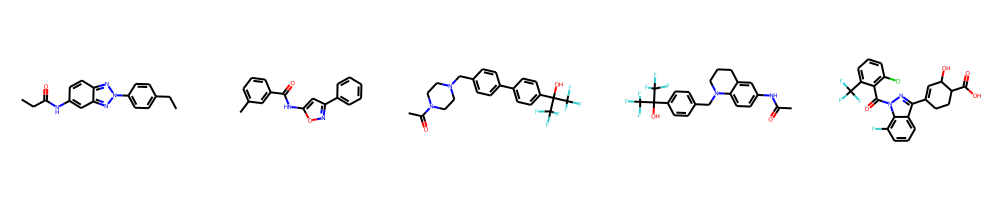

In [66]:
Draw.MolsToGridImage(smiles_trainn, molsPerRow=5, maxMols=int(len(smiles_trainn)+5))

# SEARCH for generated SMILES in PUBCHEM

In [67]:
mols[0]

'CCC(=O)NCC1=CN(C2=NC=NC(C#N)=C2C)C1SOC'

In [68]:
len(mols)

55

In [69]:
import pubchempy as pcp

In [70]:
compound = pcp.get_compounds('CC', 'smiles')

In [71]:
compound

[Compound(6324)]

### Canonical from search

In [72]:
#isomeric SMILES to canonical SMILES
mols_cann = []
for mol in mols:
    cannonical = Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=False)
    mols_cann.append(cannonical)
mols_cann[0:3]

['CCC(=O)NCC1=CN(c2ncnc(C#N)c2C)C1SOC',
 'CCC(=O)NCc1ccnn1[SH]1C=C(c2ccccc2F)NN1',
 'CCC(=O)NCc1cncc(S(=O)(=O)C(C)CC#N)n1']

In [73]:
mols_cann[0]

'CCC(=O)NCC1=CN(c2ncnc(C#N)c2C)C1SOC'

In [74]:
compounds_l = []
for smiles in mols_cann:
    try:
        
        compound = pcp.get_compounds(smiles, 'smiles')
        compounds_l.append(compound)
    except:
        #compounds_l.append('Not found...')
        print("Not found : "+str(smiles))
compounds_l

Not found : CCC(=O)NCc1ccnn1[SH]1C=C(c2ccccc2F)NN1
Not found : CCC(=O)N1c2ccn(-c3ncnc(C#N)c3C)c2[SH]1C
Not found : CC(C1=CC=C[SH]1N)C1=NN=CC=CCNC(=O)CC1
Not found : CCC(=O)NCC=CC=NN=C(NC)C(C)C1=CC=C[SH]1C


[[Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound(16445174)],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound(18006105)],
 [Compound()],
 [Compound()],
 [Compound(129773833)],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()],
 [Compound()]]

In [75]:
smiles_found_in_pubchem = []
for i in range(len(compounds_l)):
    try:
        smiles_found_in_pubchem.append(compounds_l[i][0].canonical_smiles)
    except:
        pass
smiles_found_in_pubchem_1 = []
for val in smiles_found_in_pubchem:
    if val != None :
        smiles_found_in_pubchem_1.append(val)
smiles_found_in_pubchem_1

['CC1=CC(=CC=C1)C(=O)NC2=CC(=NO2)C3=CC=CC=C3', 'CNOC=O', 'C1=NNO1']

In [76]:
# Check if one of above structures passed filtration steps

In [77]:
end = time.time()

In [78]:
print("The time of execution of above program is :", end-start)

The time of execution of above program is : 321.0688416957855
